In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from copy import deepcopy
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras import layers,models
import matplotlib.pyplot as plt
from keras.metrics import categorical_crossentropy
import tensorflow as tf
from sklearn.model_selection import train_test_split


D:\Users\MSA\anaconda3\envs\ad\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path=r'C:\Users\MSA\Desktop\project grpvine\Grapevine_Leaves_Image_Dataset'
list_file=os.listdir(f'{path}')
list_file

['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']

In [3]:
# Encoding label
calss_dic={} 
for i in range(len(list_file)):
    calss_dic[list_file[i]]=i
calss_dic    

{'Ak': 0, 'Ala_Idris': 1, 'Buzgulu': 2, 'Dimnit': 3, 'Nazli': 4}

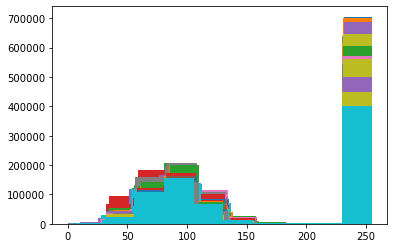

In [4]:
image_matrix=[]
label=[]

for i in range(len(list_file)):
    list_photo=os.listdir(f'{path}/{list_file[i]}')
    for j in range(len(list_photo)):
        image_temp=cv2.imread(f'{path}/{list_file[i]}/{list_photo[j]}')
        n, bins,patches=plt.hist(np.ravel(image_temp))
        mode_index = n.argmax()
        image_temp[image_temp>=bins[mode_index]]=0 # converting white background to black background
        output=cv2.resize(image_temp,(224,224))   # converting the photo size from (512x512x3) to (224x224x3)
        class_name=list_photo[j].split()[0]
        label.append(calss_dic[class_name]) # label image      
        image_matrix.append(output)  # images
        class_name=None


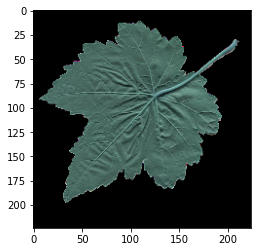

In [5]:
plt.imshow(image_matrix[120])

In [6]:
#converting label to categorical
label=tf.keras.utils.to_categorical(label,num_classes=5)
label=label.tolist()


In [7]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa


In [8]:
len_im_train=len(image_matrix)

# data augmentation
for i in range(len_im_train):
    rotate=iaa.Affine(rotate=(-45, 45))
    rotated_image=rotate.augment_image(image_matrix[i])
    
    image_matrix.append(rotated_image) 
    label.append(label[i])
   
    
    flipped_img = np.fliplr(image_matrix[i])
    
    image_matrix.append(flipped_img) 
    label.append(label[i])
    
    scale=iaa.Affine(scale=(0.8,1.2))
    scale_image =scale.augment_image(image_matrix[i])
    
    image_matrix.append(scale_image) 
    label.append(label[i])
    
    aug_translation = iaa.Affine(translate_px={"x": (-15, 15), "y": (-15, 15)})
    translation_image =aug_translation.augment_image(image_matrix[i])
    image_matrix.append(scale_image) 
    label.append(label[i])
    


In [9]:
# train and test data
im_train,im_test, label_train, label_test = train_test_split(image_matrix, label,test_size=.2,random_state=5)

In [18]:
# converting train and test data to numpy
im_train=np.asanyarray(im_train)    
label_train=np.asanyarray(label_train)
im_test=np.asanyarray(im_test)
label_test=np.asanyarray(label_test)

In [11]:
# scaling image to (0,1)
im_train=im_train.astype('float32')
im_test=im_test.astype('float32')
im_train=im_train/255.0
im_test=im_test/255.0

In [12]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [65]:
modell = MobileNetV2(weights='imagenet',input_shape=(224,224,3))
modell=Model(modell.inputs,modell.layers[-50].output)
modell.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

In [66]:
model=models.Sequential()
model.add(modell)
model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(1000,activation='relu',kernel_regularizer=regularizers.L2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(512,activation='relu',kernel_regularizer=regularizers.L2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(256,activation='relu',kernel_regularizer=regularizers.L2(0.01)))
#model.add(Dropout(0.2))
model.add(Dense(128,activation='relu',kernel_regularizer=regularizers.L2(0.01)))
#model.add(Dropout(0.1))
model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.L2(0.01)))
#model.add(Dropout(0.2))
model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.L2(0.01)))
model.add(Dropout(0.3))
model.add(layers.Dense(5,activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_10 (Functional)       (None, 14, 14, 96)        437888    
                                                                 
 flatten_10 (Flatten)        (None, 18816)             0         
                                                                 
 dense_70 (Dense)            (None, 1000)              18817000  
                                                                 
 dropout_42 (Dropout)        (None, 1000)              0         
                                                                 
 dense_71 (Dense)            (None, 512)               512512    
                                                                 
 dropout_43 (Dropout)        (None, 512)               0         
                                                                 
 dense_72 (Dense)            (None, 256)             

In [28]:
#for layesr in model.layers[0].layers[:-5]:
    #layers.trainbale=False


In [67]:
#freezing layers from flatten to last layer
for layesr in model.layers:
    layers.trainbale=False


In [68]:
opt = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.5)
#RMSprop(learning_rate=0.001)
#Adam(lr=0.001)
#Adam=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
             optimizer=RMSprop(learning_rate=0.0001),
             metrics=['accuracy'])

In [69]:
history=model.fit(im_train, label_train,
          batch_size=50, epochs=12,
          validation_data=(im_test, label_test))

Epoch 1/12
40/40 [==============================] - 249s 6s/step - loss: 33.4268 - accuracy: 0.2340 - val_loss: 31.9684 - val_accuracy: 0.2460
Epoch 2/12
40/40 [==============================] - 174s 4s/step - loss: 31.0478 - accuracy: 0.2505 - val_loss: 29.5205 - val_accuracy: 0.3560
Epoch 3/12
40/40 [==============================] - 173s 4s/step - loss: 28.3102 - accuracy: 0.3510 - val_loss: 26.7988 - val_accuracy: 0.4840
Epoch 4/12
40/40 [==============================] - 169s 4s/step - loss: 25.6714 - accuracy: 0.3905 - val_loss: 24.3673 - val_accuracy: 0.4980
Epoch 5/12
40/40 [==============================] - 169s 4s/step - loss: 23.2217 - accuracy: 0.5025 - val_loss: 22.1728 - val_accuracy: 0.5740
Epoch 6/12
40/40 [==============================] - 170s 4s/step - loss: 21.0303 - accuracy: 0.6345 - val_loss: 20.3641 - val_accuracy: 0.5800
Epoch 7/12
40/40 [==============================] - 169s 4s/step - loss: 19.2124 - accuracy: 0.7545 - val_loss: 18.6054 - val_accuracy: 0.7140

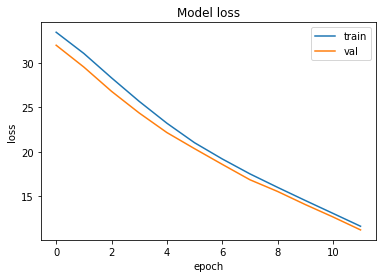

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'],loc='upper right')
plt.show()

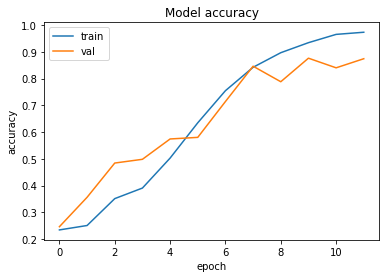

In [71]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'],loc='upper left')
plt.show()

In [72]:
model.evaluate(im_train,label_train)

63/63 [==============================] - 45s 660ms/step - loss: 11.1259 - accuracy: 0.9020


[11.125862121582031, 0.9020000100135803]

In [73]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
import seaborn  as sns

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       396
           1       0.77      1.00      0.87       393
           2       0.99      0.82      0.90       396
           3       0.99      0.75      0.85       414
           4       0.97      0.97      0.97       401

    accuracy                           0.90      2000
   macro avg       0.92      0.90      0.90      2000
weighted avg       0.92      0.90      0.90      2000



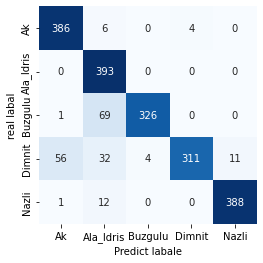

In [77]:
mat=confusion_matrix(label_train.argmax(axis=1),model.predict(im_train).argmax(axis=1))
labals=list(calss_dic.keys())
sns.heatmap(mat,square=True,annot=True,fmt='d',cbar=False,cmap='Blues',xticklabels=labals,yticklabels=labals)
plt.xlabel('Predict labale')
plt.ylabel('real labal')
print(classification_report(label_train.argmax(axis=1), model.predict(im_train).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89       104
           1       0.75      0.99      0.85       107
           2       0.99      0.72      0.83       104
           3       0.97      0.67      0.79        86
           4       0.96      0.98      0.97        99

    accuracy                           0.87       500
   macro avg       0.90      0.87      0.87       500
weighted avg       0.89      0.87      0.87       500



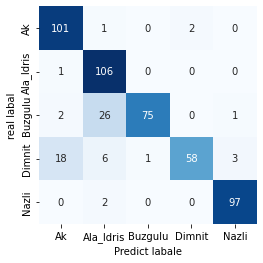

In [74]:
mat=confusion_matrix(label_test.argmax(axis=1),model.predict(im_test).argmax(axis=1))
labels=list(calss_dic.keys())
sns.heatmap(mat,square=True,annot=True,fmt='d',cbar=False,cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predict labale')
plt.ylabel('real labal')
print(classification_report(label_test.argmax(axis=1), model.predict(im_test).argmax(axis=1)))

In [78]:
new_input = model.input
hidden_layer = model.layers[2].output
model_svm = Model(new_input,hidden_layer)
model_svm.summary()


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_10_input (InputLayer)  [(None, 224, 224, 3)]    0         
                                                                 
 model_10 (Functional)       (None, 14, 14, 96)        437888    
                                                                 
 flatten_10 (Flatten)        (None, 18816)             0         
                                                                 
 dense_70 (Dense)            (None, 1000)              18817000  
                                                                 
Total params: 19,254,888
Trainable params: 19,241,256
Non-trainable params: 13,632
_________________________________________________________________


In [82]:
def featur_extract(image,label):
    image_featur=[]
    for i in range(len(image)):
        if i==0:
            fe_0=model_svm.predict(image[0:1]).tolist()
            label_0=np.argmax(label[0])
            fe_0[0].append(label_0)
            data=pd.DataFrame(fe_0[0]).T
        else:
            fe_0=model_svm.predict(image[i:i+1]).tolist()
            label_0=np.argmax(label[i])
            fe_0[0].append(label_0)
            data.loc[len(data.index)] = fe_0[0]
    return data

In [83]:
image_featur=featur_extract(im_train,label_train)

In [85]:
image_featur

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,0.000000,0.000000,0.000000,3.903670,0.618411,3.296085,0.000000,2.302590,5.061228,8.640326,...,5.896492,2.337579,4.079474,4.754255,3.270254,0.000000,14.258305,0.00000,0.0,4.0
1,1.384075,1.021107,0.000000,5.328544,0.159214,4.776149,0.000000,5.200228,8.625793,13.498273,...,4.256945,0.000000,3.766289,0.000000,3.833842,6.706434,12.004204,0.00000,0.0,1.0
2,0.000000,0.517260,0.000384,1.712764,1.834664,3.531218,0.196011,2.311676,7.803082,10.317826,...,5.267743,0.687278,0.895861,0.000000,5.048385,0.000000,10.807325,0.00000,0.0,3.0
3,1.072565,0.267666,0.857652,0.322843,0.580518,5.271102,0.000000,9.457518,6.676069,4.233595,...,7.816875,2.228269,10.531533,4.986290,3.932420,1.813889,11.743783,0.00000,0.0,1.0
4,0.000000,0.000000,0.000000,3.226720,2.570532,4.116775,0.000000,2.804457,1.814343,7.375148,...,4.581301,0.977405,6.558069,0.790439,0.000000,6.509341,10.467485,0.00000,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.159848,1.662396,0.000000,4.527588,0.040551,4.717863,0.000000,1.457833,0.116914,7.552509,...,4.359893,1.311670,10.282094,0.740782,2.933260,5.041476,9.724679,0.09328,0.0,1.0
1996,0.000000,0.000000,0.000000,0.000000,1.027813,3.384523,0.000000,0.881145,4.712196,5.783883,...,6.526497,1.639425,2.516441,0.000000,2.377720,1.665594,12.547537,0.00000,0.0,4.0
1997,0.000000,0.000000,0.000000,0.000000,0.000000,4.071754,0.000000,1.829075,4.423389,6.121238,...,5.479603,1.694971,10.115057,2.325082,3.331149,3.788919,10.631037,0.00000,0.0,2.0
1998,0.000000,0.918869,0.000000,0.000000,0.000000,3.761041,0.521165,6.845826,7.337324,10.881554,...,5.238353,1.729602,4.944438,2.738106,6.138870,2.466654,11.926782,0.00000,0.0,3.0


In [121]:
for i in range(len(image_featur.columns)-1):
    image_featur.rename(columns={image_featur.columns[i]:'x_'+str(i+1)},inplace=True)
image_featur.rename(columns={image_featur.columns[-1]:'label'},inplace=True)    

In [ ]:
image_featur_t=featur_extract(im_test,label_test)

In [ ]:
for i in range(len(image_featur_t.columns)-1):
    image_featur.rename(columns={image_featur_t.columns[i]:'x_'+str(i+1)},inplace=True)
image_featur.rename(columns={image_featur_t.columns[-1]:'label'},inplace=True) 

In [128]:
image_featur_t

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_992,x_993,x_994,x_995,x_996,x_997,x_998,x_999,x_1000,label
0,0.000000,0.000000,4.033556,4.780286,4.455083,6.468021,1.900689,6.496203,3.303523,10.384313,...,5.488605,1.231207,9.281067,0.840118,3.330353,4.737803,5.844235,0.000000,0.0,1.0
1,4.552824,0.890375,0.000000,0.000000,0.949323,4.968728,0.000000,6.732484,0.000000,7.140462,...,3.812512,0.488252,6.084234,0.000000,4.087474,5.744403,4.478822,0.119160,0.0,2.0
2,0.000000,0.000000,0.000000,3.401283,0.000000,2.985926,1.159650,1.885265,2.859578,6.365333,...,4.570410,2.817298,2.964750,4.002781,2.773384,0.000000,7.357368,0.000000,0.0,0.0
3,1.761717,1.835865,0.000000,3.662821,2.799620,3.810786,0.330441,5.557062,0.572706,8.535141,...,5.552164,1.164635,8.739484,5.019611,5.687132,0.814032,6.121414,0.000000,0.0,1.0
4,0.000000,0.951123,0.000000,0.000000,0.000000,3.138533,0.000000,4.382830,9.333317,4.631620,...,5.638612,0.540224,6.046758,0.208130,6.747833,2.127941,14.640097,0.000000,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2.522287,0.799473,0.000000,0.000000,0.000000,4.698646,0.698803,3.544345,2.924271,6.840326,...,5.567515,2.253359,3.805427,3.458621,3.872942,0.000000,2.815104,0.000000,0.0,0.0
496,0.000000,0.000000,0.000000,0.000000,1.121408,3.225031,0.000000,0.000000,6.329382,8.125407,...,5.556175,2.393286,2.971611,2.514559,2.514826,0.000000,12.124785,0.000000,0.0,0.0
497,0.000000,0.000000,0.000000,0.935785,0.000000,4.336132,0.000000,2.890790,4.101186,8.231086,...,5.722170,1.208907,0.169521,2.132295,5.384986,3.675720,6.683661,0.000000,0.0,3.0
498,0.000000,2.290989,0.000000,0.000000,0.000000,3.390636,2.182550,12.650620,2.199661,3.730094,...,4.095864,1.344687,7.554296,0.000000,13.439259,2.605560,7.941398,0.000000,0.0,4.0
